# [Colorful Dim](https://forums.fast.ai/t/the-colorful-dimension/42908)

# [Also Take A Look At Bottom Page There](https://nbviewer.org/github/fastai/fastbook/blob/master/13_convolutions.ipynb)

In [1]:
dependencies = [
    "kagtool",
    "kaggle",
    "fastai",
    "nbdev",
    "datasets"
]

!pip install -U {" ".join(dependencies)}

from fastai.imports import *

In [2]:
import gc

from fastai.imports import *
from fastai.vision.all import *
import matplotlib.pyplot as plt

In [3]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#3) [Path('.DS_Store'),Path('training'),Path('testing')]

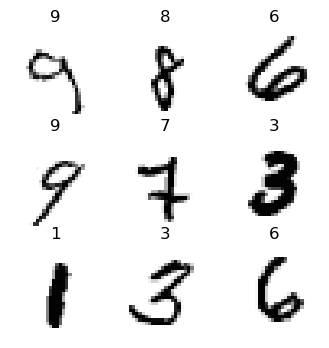

In [5]:
def get_dls(bs=128):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()
dls.show_batch(max_n=9, figsize=(4,4))

In [11]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #next inputs = 14x14
        conv(8 ,16),             #next inputs = 7x7
        conv(16,32),             #next inputs = 4x4
        conv(32,64),             #next inputs = 2x2
        conv(64,10, act=False),  #next inputs = 1x1
        Flatten(),
    )

In [6]:
from fastai.callback.hook import *

# Why We Can't Train With A Fixed Learning Schedule

### Fit Without Scheduling

In [15]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, lr)
    return learn

In [16]:
learn = fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.305286,2.302283,0.113500,00:43
1,2.304262,2.301468,0.113500,00:42
2,2.303960,2.305880,0.102800,00:42


This didn't train at all well! Let's find out why

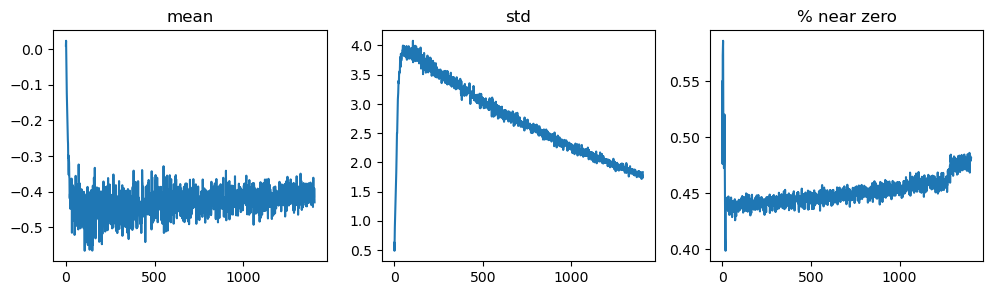

In [18]:
learn.activation_stats.plot_layer_stats(0)

- almost 50% of near zero activations! That's problematic because it means we have computation in the model that's doing nothing at all
- Also usually we want to see mean go down and std go up in smooth ways

Let's take another look at the result for the penultimate layer:

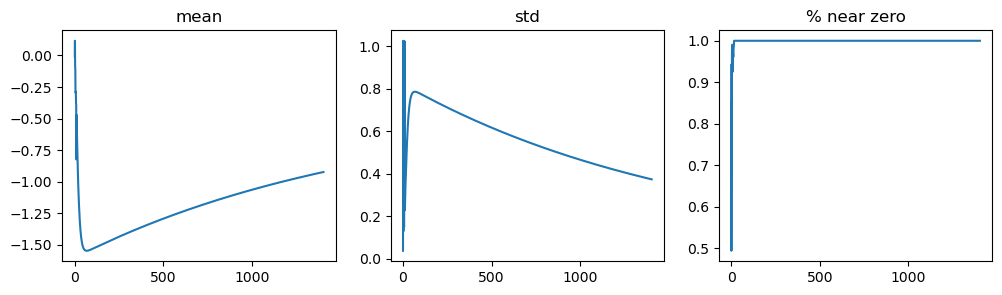

In [19]:
learn.activation_stats.plot_layer_stats(-2)

Yep it gets worse

### fit_one_cycle

One common reason is either bad weight initilization or bad optimizer/learning rate scheduling, let's start by learning rate scheduling since it's easier:

In [20]:
def fit_one_cycle(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn
learn = fit_one_cycle()

epoch,train_loss,valid_loss,accuracy,time
0,0.147988,0.103509,0.967600,00:42


WAYY BETTER! Notice the curve of the learning rate and momentum

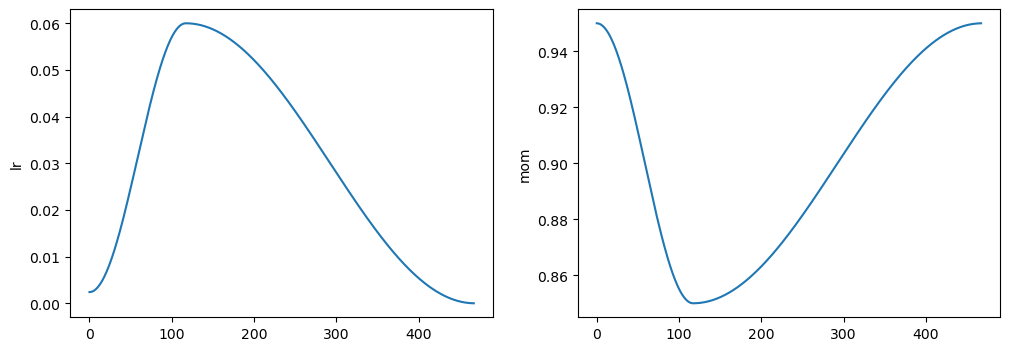

In [21]:
learn.recorder.plot_sched()

In [ ]:
learn.activation_stats.plot_layer_stats(0)
learn.activation_stats.plot_layer_stats(-2)

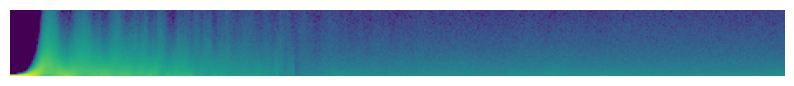

In [22]:
# that's the final activation of the model before the flatten
learn.activation_stats.color_dim(-2)

That's bad we should see:
- less spikes
- more and more green toward the right, not more dark

# BatchNorm

Using batch norm to get better initialization and solve the spikes at the beginning of color dim

In [23]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [24]:
learn = fit_one_cycle()

/Users/cactus/miniconda3/lib/python3.12/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.060219,0.040805,0.987900,00:45


In [25]:
learn.model[-2]

Sequential(
  (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

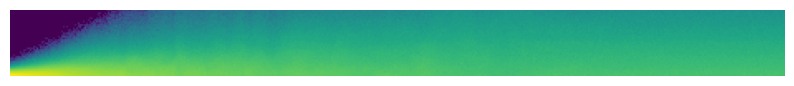

In [26]:
# for some reason the color_dim index to use here is -4, i dunno why
# maybe do -2 to end at that sequential block
# then -2 again to get to the block before the batch norm?
learn.activation_stats.color_dim(-4)

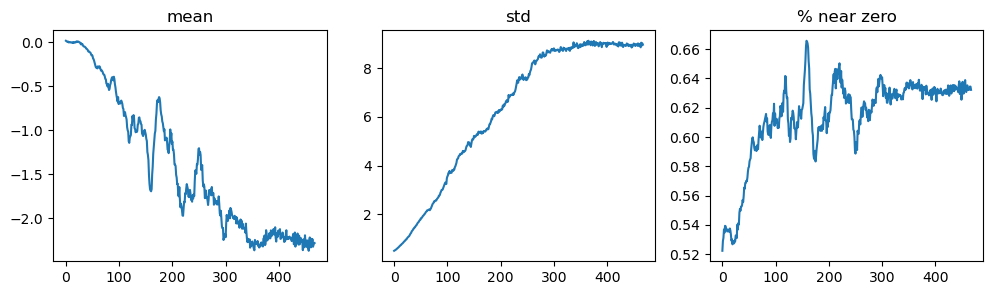

In [27]:
# not even sure if the index is correct here
learn.activation_stats.plot_layer_stats(-4)

Anyway that's what we want look at! A Half Beautiful Bell Curve

In [28]:
# let's finish with more epochs
learn = fit_one_cycle(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.116555,0.118577,0.963500,00:42
1,0.080240,0.079710,0.975800,00:40
2,0.061013,0.050492,0.985100,00:42
3,0.037548,0.029122,0.991200,00:41
4,0.017943,0.024282,0.992900,00:41


# What Good Activations Should Look Like

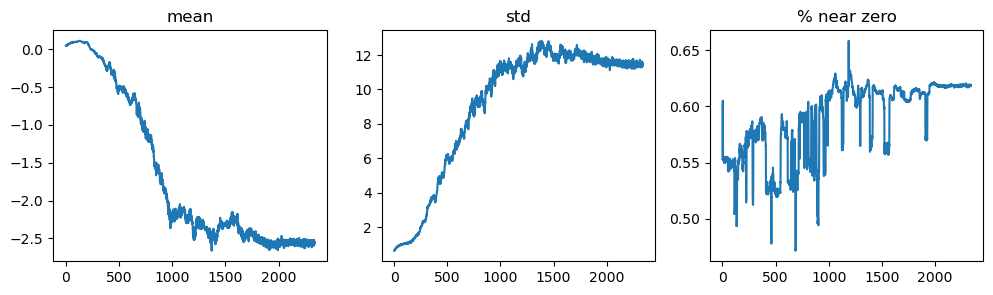

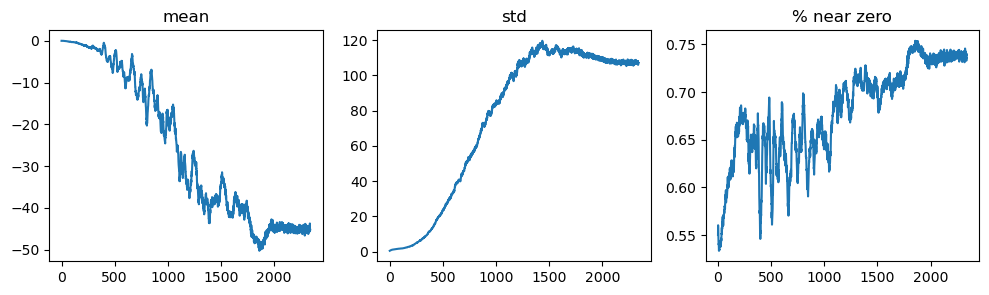

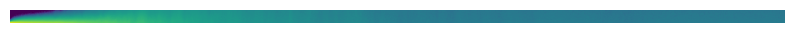

In [30]:
learn.activation_stats.plot_layer_stats(0)
learn.activation_stats.plot_layer_stats(-4)
learn.activation_stats.color_dim(-4)